<a href="https://www.kaggle.com/code/fizcogar/intro-ia-4-covid19-la-importancia-de-los-datos?scriptVersionId=115880650" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Introducción a la Inteligencia Artificial
## Aprendizaje Profundo

### Diagnóstico de COVID-19 a partir de radiografías de tórax

Queremos construir un modelo de DL para diagnosticar COVID-19 a partir de las radiografías de los pacientes.
* Es un problema de **clasificación** de **imagen digital**.
* La entrada (X) son las **radiografías**, la salida (Y) si **muestran o no COVID**.

Los datos los obtenemos de dos datasets públicos:
* Pacientes con **neumonía por COVID-19**: https://github.com/ieee8023/covid-chestxray-dataset
* Pacientes con **otras neumonías víricas** (publicado en marzo de 2018): https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

El dataset de pacientes con COVID-19 no tiene suficientes radiografías de pacientes sin covid, por eso necesitamos otro del que hemos extraído radiografías de pacientes con otras neumonías víricas.

En total tenemos unas 200 de cada tipo.

El objetivo del clasificador es, por tanto, diferenciar neumonías covid de otras neumonías víricas.

## Aprendizaje profundo (deep learning)

¿Podría resolverse este problema con alguno de los modelos que hemos visto? (regresión lineal, árboles de decisión ...)

Obtendríamos un modelo con una cierta precisión, pero nunca sería un modelo viable.

De hecho un modelo para clasificar códigos postales escritos a mano llevó a la construcción de la primera red neuronal en Bell Labs en 1989.

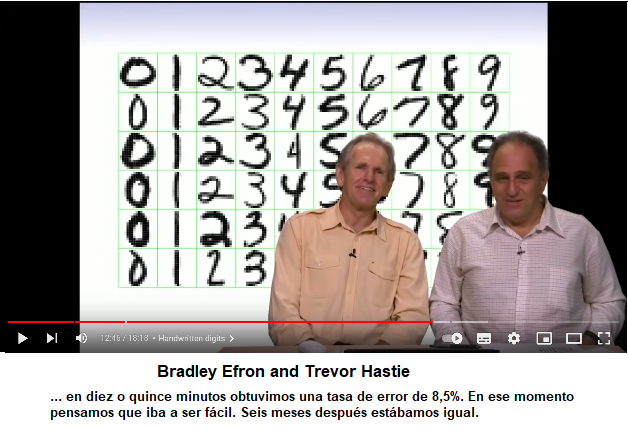

https://www.youtube.com/watch?v=5N9V07EIfIg

> Pregunta de nota: ¿Cuántos parámetros tendría un modelo de regresión lineal que tratara de resolver este problem?

## fast.ai

Este es un problema de imagen digital, y entra dentro de lo que se considera **aprendizaje profundo**. En lugar de scikit-learn vamos a usar **[fast.ai](http://https://www.fast.ai/)**, una librería orientada a esta técnica de aprendizaje máquina.

Fast.ai debe su nombre a que está pensada para el desarrollo rápido: es menos flexible pero más fácil de usar que otras como [TensorFlow](https://www.tensorflow.org) o [Pytorch](http://https://pytorch.org/), que son de más bajo nivel de abstracción. La propia fast.ai está basada en Pytorch.

Además de la librería publican cursos on-line gratuitos muy recomendables:
* [Practical Deep Learning for Coders](https://course.fast.ai/)
* [Practical Data Ethics](http://)

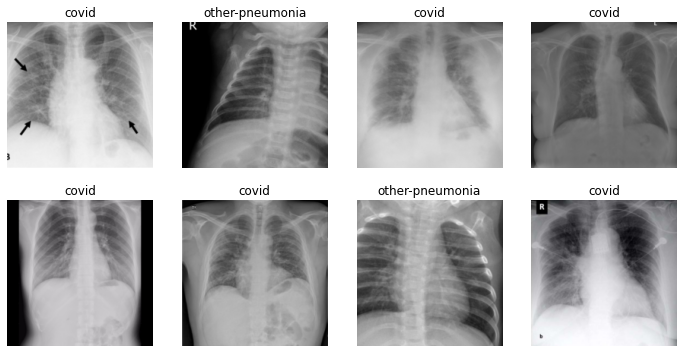

In [1]:
from fastai.vision.all import *

path = Path('/kaggle/input/covid-bias')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=666),
    get_y=parent_label,
    item_tfms=[Resize(192)]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

## Métricas

Una **métrica** es una medida que, al igual que la **pérdida**, nos dice lo bien o mal que lo está haciendo nuestro modelo, pero que mide mejor el error para cada caso concreto. En este caso indicamos que la métrica que queremos que nos muestre el modelo es el **ratio de error (error_rate)**, que es el porcentaje de fallos que comete.

Supongamos que tenemor sólo 3 rediografías para validar el modelo.

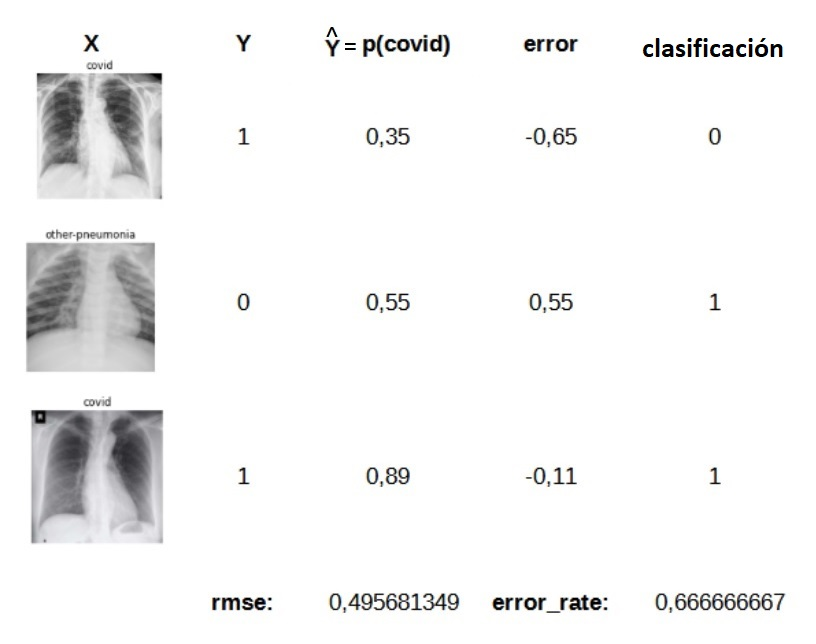

* La predicción del modelo es la probabilidad, entre 0 y 1, de que la entrada (la radiografía) corresponda con una clase (covid).
    * Podemos calcular la perdida como un error medio (por ejemplo, rmse)
* La salida del modelo no es la probabilidad: es 0 si la probabilidad es menor que 0.5 y 1 si es mayor que 0.5
    * Podemos calcular el porcentaje de fallos (ratio de error), que es una métrica mucho más fácil de interpretar

Si el modelo funciona un poco mejor ...

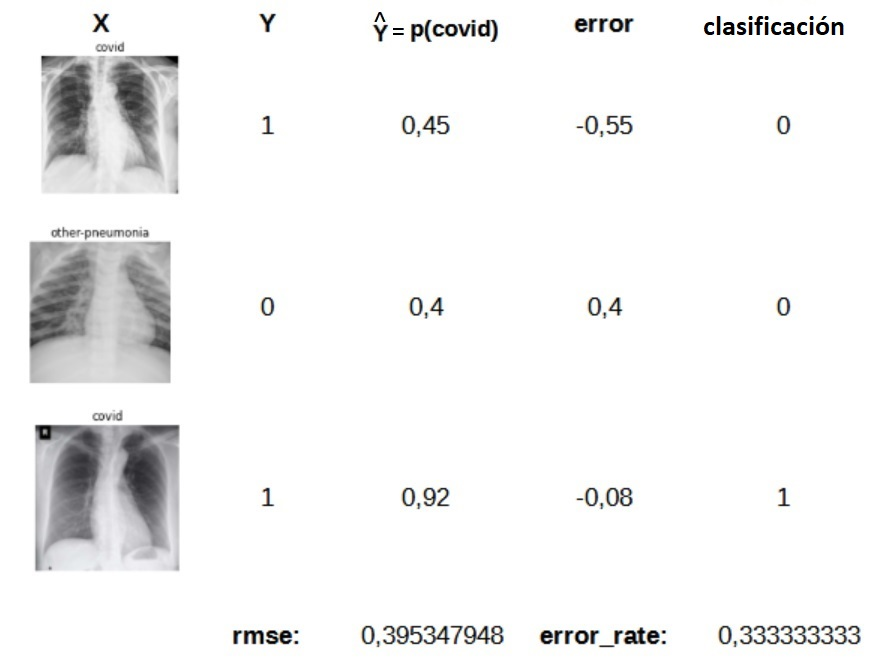

## Modelo sin preentramiento

Para probar la transferencia de aprendizaje, el primer experimento es con un modelo **resnet18 sin preentrenar**:

In [2]:
learn = vision_learner(dls, resnet18, metrics=error_rate, pretrained=False)

In [3]:
learn.fit(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.940802,2.022282,0.582278,00:21
1,0.655689,2.137022,0.455696,00:10
2,0.516604,0.538043,0.113924,00:11
3,0.424614,0.563701,0.177215,00:10


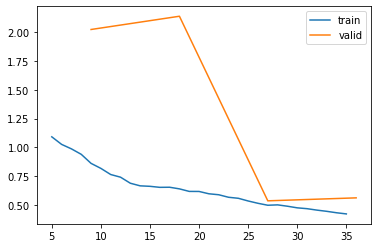

In [4]:
learn.recorder.plot_loss()

## Modelo preentrenado

Y ahora, a partir del modelo preentrenado. La arquitectura es [resnet18](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights), preentrenada con [Imagenet](https://www.image-net.org/)

Fíjate que ahora **descarga el modelo de Internet**

In [5]:
learn = vision_learner(dls, resnet18, metrics=error_rate, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

En el sumario del modelo vemos que una parte de la red neuronal está 'congelada' `(Model frozen up to ...)`, solo entrenaremos las últimas capas.

In [6]:
learn.summary()

Sequential (Input shape: 32 x 3 x 192 x 192)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 96 x 96   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 48 x 48   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [7]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.777767,0.198354,0.088608,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.184893,0.175838,0.063291,00:11
1,0.157524,0.096244,0.025316,00:10
2,0.109425,0.051133,0.025316,00:11
3,0.078082,0.039984,0.012658,00:11


Podemos ver la curva de la pérdida, para los 'datasets' de entrenamiento y de validación:

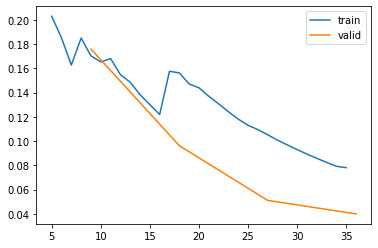

In [8]:
learn.recorder.plot_loss()

## Matriz de confusión

Presenta los aciertos y fallos en una tabla

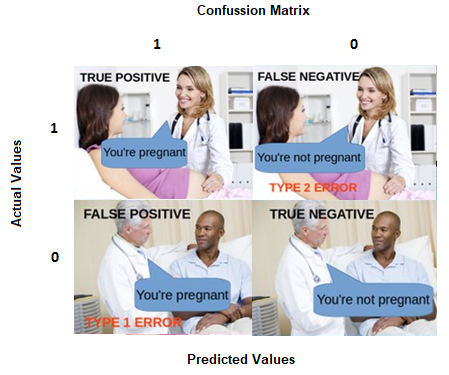

## Coste de los falsos positivos o negativos.

¿Qué error tiene mayor **'coste'**, que un modelo de ML que diagnostica COVID identifique a **una persona sana como enferma** (falso positivo) o que identifique a una persona **enferma como sana** (falso negativo)?

En general será más costoso **no diagnosticar correctamente a un enfermo**.

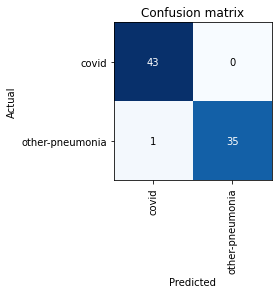

In [9]:
interprete = ClassificationInterpretation.from_learner(learn)
interprete.plot_confusion_matrix()

Con transferencia de aprendizaje el resultado es mejor. ¡De echo, el resultado es muy bueno! 

**¿Demasiado bueno?**

## La importancia de los datos

Este caso de uso está inspirado en [una publicación](https://www.nature.com/articles/s42256-021-00307-0) de la revista Nature, en el que evalúan hasta 62 publicaciones sin validez científica por diversos motivos. En 16 de ellos se utilizó este dataset de [Kermany et al.](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) sin mencionar que son radiografías pediátricas, de niños entre uno y cinco años.

> [Common pitfalls and recommendations for using machine learning to detect and prognosticate for COVID-19 using chest radiographs and CT scans](https://www.nature.com/articles/s42256-021-00307-0)
>
> "Many papers (16/62) used the pneumonia dataset of Kermany et al. as a control group. 
> They commonly failed to mention that this consists of **paediatric patients** aged between one and five. 
> Developing a model using adult patients with COVID-19 and very young patients with pneumonia is 
> likely to overperform as it is **merely detecting children versus adults.**"

Nuestro modelo encuentra en una clase **radiografías de adultos con Covid-19**, y, en la otra, **radiografías de niños con otras infecciones víricas**. Hay muchas más diferencias entre las radiografías de adultos y las radiografías de niños que entre las de enfermos con Covid-19 y las de enfermos con otras infecciones víricas, por lo que nuestro modelo aprende a identificar **patrones que diferencian radiografías de adultos de radiografías de niños**.

## Viabilidad del proyecto 

En una búsqueda rápida he encontrado [un informe](https://www.cochrane.org/es/CD013639/INFECTN_que-exactitud-tienen-las-imagenes-de-torax-para-el-diagnostico-de-la-covid-19) sobre un estudio realizado sobre 37.631 diagnósticos basados en radiografías, tomografías computerizadas y ecografías de tórax, de los cuales el 53% tuvieron un diagnóstico final de covid-19.

El estudio encontró que **sólo el 73% de los diagnósticos basados en radiografías de tórax fueron correctos**. Los resultados fueron mejores en los diagnósticos basados en tomografías y en ecografías, alcanzando en ambos casos un 87% de exactitud.

Teniendo esto en cuenta, y dependiendo de la precisión mínima que los especialistas médicos consideren para que un sistema así sea de utilidad, el proyecto podría considerarse poco viable, ya que, como hemos visto, es difícil que un sistema de aprendizaje profundo sea mucho mejor que los especialistas humanos.